In [24]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from sklearn.ensemble import IsolationForest
from scipy.stats import zscore

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# import warnings
# warnings.filterwarnings("ignore")

In [25]:
training=pd.read_csv('training_data.csv', sep=',')
test=pd.read_csv('songs_to_classify.csv', sep=',')
training.sample(5)

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,label
130,0.687000,0.341,181400,0.975,0.904000,0,0.3520,-4.033,1,0.0933,146.976,3,0.446,1
667,0.000031,0.444,202307,0.995,0.000002,7,0.1900,-2.097,1,0.1710,79.999,5,0.285,0
688,0.004460,0.731,179467,0.950,0.000036,2,0.3620,-2.705,1,0.0516,135.081,4,0.249,0
670,0.142000,0.768,247040,0.768,0.000000,0,0.0664,-6.699,1,0.2530,136.943,4,0.465,0
472,0.000160,0.520,255000,0.953,0.651000,0,0.3540,-4.527,1,0.0548,127.968,4,0.573,0


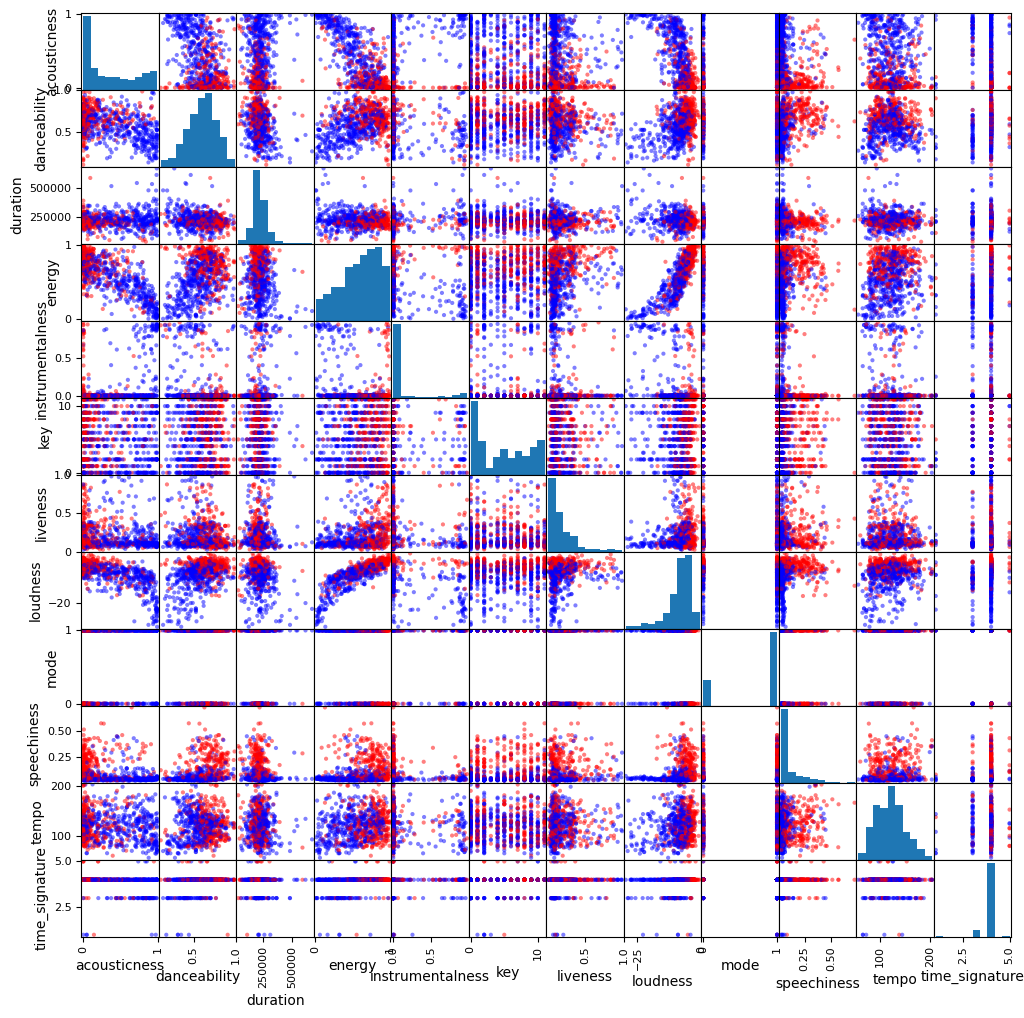

In [26]:
cols = list(map(lambda x: "red" if x == 0 else "blue", training.iloc[:,13]))
feature_selection = range(0, 12) # change here to study other features
pd.plotting.scatter_matrix(training.iloc[:,feature_selection], c=cols, figsize=(12, 12));

In [27]:
# Q1 = training.quantile(0.25)
# Q3 = training.quantile(0.75)
# IQR = Q3 - Q1

# criteria = 1.7
# outlier_condition = (training < (Q1 - criteria * IQR)) | (training > (Q3 + criteria * IQR))

# mask = ~outlier_condition.any(axis=1)
# training = training[mask]

# cols = list(map(lambda x: "red" if x == 0 else "blue", training.iloc[:,13]))
# pd.plotting.scatter_matrix(training.iloc[:,feature_selection], c=cols, figsize=(12, 12));

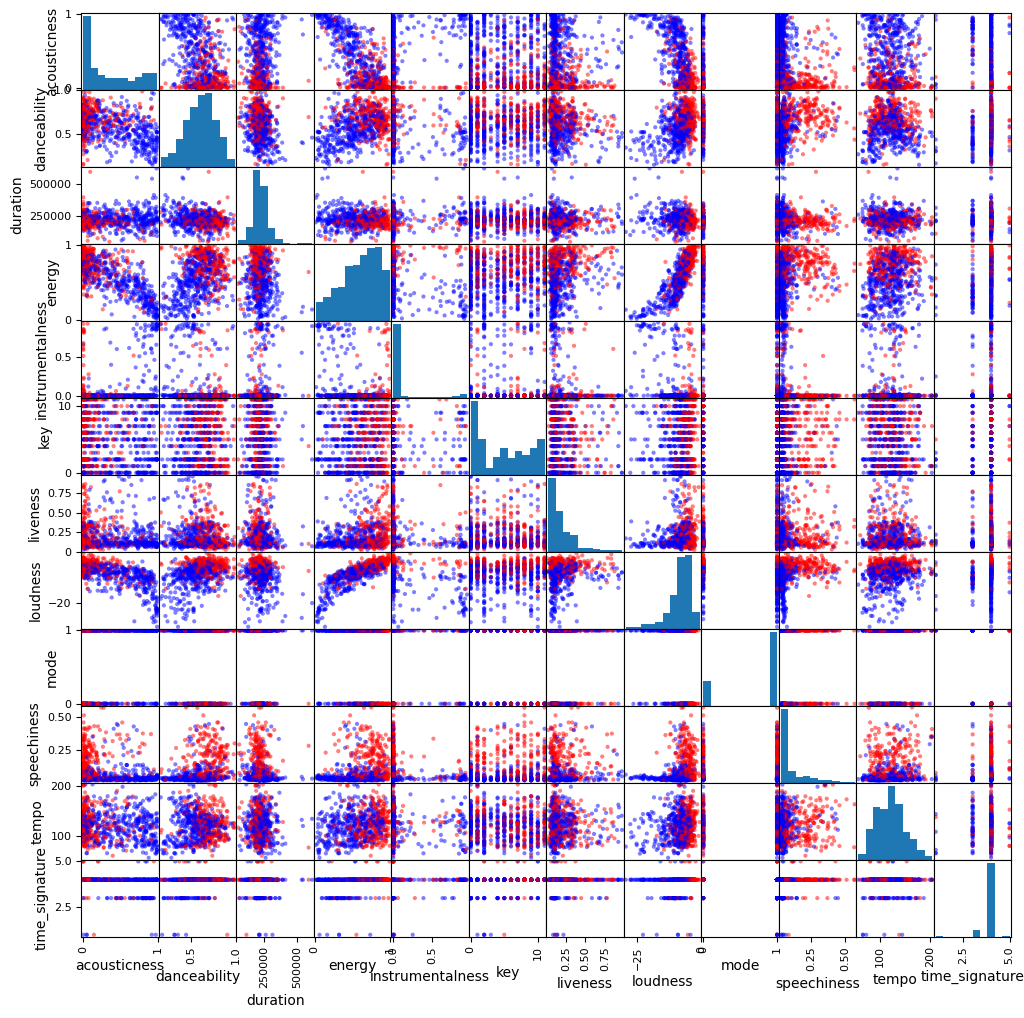

In [28]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest model
model = IsolationForest(contamination=0.03, random_state=42,  n_jobs=-1)  # Set contamination to desired outlier proportion

# Fit the model and predict outliers (-1 means outlier, 1 means inlier)
outliers = model.fit_predict(training)

# Keep only inliers (rows labeled as 1)
cleaned_data = training[outliers == 1]

cols = list(map(lambda x: "red" if x == 0 else "blue", cleaned_data.iloc[:,13]))
feature_selection = range(0, 12) # change here to study other features
pd.plotting.scatter_matrix(cleaned_data.iloc[:,feature_selection], c=cols, figsize=(12, 12));

In [29]:
# use cleaned data
X, y = training.iloc[:, 0:12], training.iloc[:, 13]
x_dummy, x_test, y_dummy, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

training = cleaned_data
X, y = training.iloc[:, 0:12], training.iloc[:, 13]
x_train, x_dummy, y_train, y_dummy = train_test_split(X, y, test_size=0.30, random_state=42)

In [30]:
np.random.seed(37)

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=3)]

for clf in classifiers:
    clf.fit(x_train, y_train)
    score = clf.score(x_test, y_test)
    print("{} test accuracy: {}".format(clf.__class__.__name__, score))

KNeighborsClassifier test accuracy: 0.6977777777777778
DecisionTreeClassifier test accuracy: 0.8444444444444444


In [31]:
pipelines = [Pipeline([('scaler', StandardScaler()), ('clf', clone(clf))]) for clf in classifiers]

for pipeline in pipelines:
    pipeline.fit(x_train, y_train)
    score = pipeline.score(x_test, y_test)
    print("Scaled {} test accuracy: {}".format(pipeline['clf'].__class__.__name__, score))

Scaled KNeighborsClassifier test accuracy: 0.84
Scaled DecisionTreeClassifier test accuracy: 0.8444444444444444


In [32]:
rng = np.random.RandomState(0)
clf = RandomForestClassifier(bootstrap=True, max_samples=0.6, n_estimators=1000, random_state=rng, max_features= 'log2', n_jobs = -1, warm_start = True)
clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
print("Test accuracy: {}".format(score))

Test accuracy: 0.9466666666666667


In [33]:
pipeline = Pipeline([('scaler', StandardScaler()), ('clf', clone(clf))])
pipeline.fit(x_train, y_train)
score = pipeline.score(x_test, y_test)
print("Scaled {} test accuracy: {}".format(pipeline['clf'].__class__.__name__, score))

Scaled RandomForestClassifier test accuracy: 0.9555555555555556


In [34]:
clf = KNeighborsClassifier()

test = np.arange(1,20,1).tolist()

param_grid = {
    'n_neighbors': test,
    'weights': ["uniform", "distance", "None"],
    'algorithm': ["ball_tree", "kd_tree", "brute", "auto"],
    }

search = GridSearchCV(clf, param_grid, cv=5, verbose=1)

search.fit(x_train, y_train)
score = search.score(x_test, y_test)
print("Best CV score: {} using {}".format(search.best_score_, search.best_params_))
print("Test accuracy: {}".format(score))

Fitting 5 folds for each of 228 candidates, totalling 1140 fits
Best CV score: 0.6240535818287711 using {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'uniform'}
Test accuracy: 0.6711111111111111


c:\Users\Jonathan Olsson\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
380 fits failed out of a total of 1140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
380 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Jonathan Olsson\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Jonathan Olsson\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\Jonathan Olsson\AppData\Local\Programs\Python

In [35]:
# pipelines = Pipeline([('scaler', StandardScaler()), ('clf', clone(clf))])

clf = KNeighborsClassifier(algorithm= 'ball_tree', n_neighbors=5, weights= 'uniform')
pipeline = Pipeline([('scaler', StandardScaler()), ('clf', clone(clf))])
pipeline.fit(x_train, y_train)
score = pipeline.score(x_test, y_test)
print("Scaled {} test accuracy: {}".format(pipeline['clf'].__class__.__name__, score))

Scaled KNeighborsClassifier test accuracy: 0.8044444444444444


In [36]:
logitmodel = LogisticRegression(max_iter=100,tol=1,C=0.001)
logitmodel.fit(x_train, y_train)
score = logitmodel.score(x_test, y_test)
print('{0:.4f}'.format(score))

0.5956


In [37]:
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(x_train, y_train)
score = svm_model.score(x_test, y_test)
print('{0:.4f}'.format(score))

0.6267


In [38]:
pipeline = Pipeline([('scaler', StandardScaler()), ('clf', clone(svm_model))])
pipeline.fit(x_train, y_train)
score = pipeline.score(x_test, y_test)
print("Scaled {} test accuracy: {}".format(pipeline['clf'].__class__.__name__, score))

Scaled SVC test accuracy: 0.8444444444444444


In [39]:
base_estimator = DecisionTreeClassifier(max_depth=1)
ada_model = AdaBoostClassifier(estimator=base_estimator, n_estimators=1000, learning_rate=1.0, random_state=rng)
ada_model.fit(x_train, y_train)

score = ada_model.score(x_test, y_test)
print('{0:.4f}'.format(score))

c:\Users\Jonathan Olsson\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.8978


In [40]:
pipeline = Pipeline([('scaler', StandardScaler()), ('clf', clone(ada_model))])
pipeline.fit(x_train, y_train)
score = pipeline.score(x_test, y_test)
print("Scaled {} test accuracy: {}".format(pipeline['clf'].__class__.__name__, score))

c:\Users\Jonathan Olsson\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Scaled AdaBoostClassifier test accuracy: 0.9155555555555556


In [41]:
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(x_train, y_train)
score = qda_model.score(x_test, y_test)
print("Scaled {} test accuracy: {}".format(pipeline['clf'].__class__.__name__, score))

Scaled AdaBoostClassifier test accuracy: 0.76


In [44]:
pipeline = Pipeline([('scaler', StandardScaler()), ('clf', clone(qda_model))])
pipeline.fit(x_train, y_train)
score = qda_model.score(x_test, y_test)
print("Scaled {} test accuracy: {}".format(qda_model['clf'].__class__.__name__, score))

TypeError: 'QuadraticDiscriminantAnalysis' object is not subscriptable

In [43]:
clf = QuadraticDiscriminantAnalysis()

param_grid = {
    'reg_param': [0.0, 0.1, 0.2, 0.5, 0.7, 1.0],  # Regularization parameters to try
    'tol': [1e-4, 1e-3, 1e-2, 1e-1],  # Different tolerance values
    'store_covariance': [True, False]
    }

search = GridSearchCV(clf, param_grid, cv=5, verbose=1)

search.fit(x_train, y_train)
score = search.score(x_test, y_test)
print("Best CV score: {} using {}".format(search.best_score_, search.best_params_))
print("Test accuracy: {}".format(score))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best CV score: 0.7520481459910696 using {'reg_param': 0.0, 'store_covariance': True, 'tol': 0.0001}
Test accuracy: 0.76
